# Sentiment classification - close to the state of the art

The task of classifying sentiments of texts (for example movie or product reviews) has high practical significance in online marketing as well as financial prediction. This is a non-trivial task, since the concept of sentiment is not easily captured.

For this assignment you have to use the larger [IMDB sentiment](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) benchmark dataset from Stanford, an achieve close to state of the art results.

The task is to try out multiple models in ascending complexity, namely:

1. TFIDF + classical statistical model (eg. RandomForest)
2. LSTM classification model
3. LSTM model, where the embeddings are initialized with pre-trained GloVe vectors
4. fastText model
5. BERT based model (you are advised to use a pre-trained one and finetune, since the resource consumption is considerable!)

You should get over 90% validation accuracy (though nearly 94 is achievable).

You are allowed to use any library or tool, though the Keras environment, and some wrappers on top (ie. Ktrain) make your life easier.





__Groups__
This assignment is to be completed individually, two weeks after the class has finished. For the precise deadline please see canvas.

__Format of submission__
You need to submit a pdf of your Google Collab notebooks.

__Due date__
Two weeks after the class has finished. For the precise deadline please see canvas.

Grade distribution:
1. TFIDF + classical statistical model (eg. RandomForest) (25% of the final grade)
2. LSTM classification model (15% of the final grade)
3. LSTM model, where the embeddings are initialized with pre-trained GloVe vectors (15% of the final grade)
4. fastText model (15% of the final grade)
5. BERT based model (you are advised to use a pre-trained one and finetune it, since the resource consumption is considerable!) (30% of the final grade). For BERT you should get over 90% validation accuracy (though nearly 94% is achievable).


__For each of the models, the marks will be awarded according to the following three criteria__:

(1) The (appropriately measured) accuracy of your prediction for the task. The more accurate the prediction is, the better. Note that you need to validate the predictive accuracy of your model on a hold-out of unseen data that the model has not been trained with.

(2) How well you motivate the use of the model - what in this model's structure makes it suited for representing sentiment? After using the model for the task how well you evaluate the accuracy you got for each model and discuss the main advantages and disadvantages the model has in the particular modelling task. At best you take part of the modelling to support your arguments.

(3) The consistency of your take-aways, i.e. what you have learned from your analyses. Also, analyze when the model is good and when and where it does not predict well.

Please make sure that you comment with # on the separates steps of the code you have produced. For the verbal description and analyses plesae insert markdown cells.


__Plagiarism__: The Frankfurt School does not accept any plagiarism. Data science is a collaborative exercise and you can discuss the research question with your classmates from other groups, if you like. You must not copy any code or text though. Plagiarism will be prosecuted and will result in a mark of 0 and you failing this class.

After carefully reading this document and having had a look at the data you may still have questions. Please submit those question to the public Q&A board in canvas and we will answer each question, so 

In [2]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz
!ls

--2019-12-19 23:10:20--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  20.3MB/s    in 6.9s    

2019-12-19 23:10:28 (11.6 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

aclImdb  aclImdb_v1.tar.gz  sample_data


In [0]:
%%capture
!python -m spacy download en_core_web_sm
!pip install spacy gensim pprint

In [3]:
data_full = '/content/aclImdb'
folder_names = ['neg','pos']

#loading the contents of the dataset for analysis
!ls {data_full}

#Loading the training data, the contents in the train folder
!ls {data_full}/train
!ls {data_full}/train/pos | head

#Loading the test data, the contents in the test folder
!ls {data_full}/test
!ls {data_full}/test/pos | head

imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt
0_9.txt
10000_8.txt
10001_10.txt
10002_7.txt
10003_8.txt
10004_8.txt
10005_7.txt
10006_7.txt
10007_7.txt
10008_7.txt
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
0_10.txt
10000_7.txt
10001_9.txt
10002_8.txt
10003_8.txt
10004_9.txt
10005_8.txt
10006_7.txt
10007_10.txt
10008_8.txt


#1. TFIDF + classical statistical model (eg. RandomForest) 

In [4]:
# load packages
import glob
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble

from sklearn.utils import shuffle
import numpy as np
import string
import pandas as pd
from nltk.stem.porter import PorterStemmer
import re
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en import English
spacy.load('en')
parser = English()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#Load text files from train folder
pos_train_files = glob.glob('/content/aclImdb/train/pos' + "/*.txt")
neg_train_files = glob.glob('/content/aclImdb/train/neg' + "/*.txt")

In [0]:
#read text files from train folder
pos_train_text = []
pos_train_labels = []
for txt in pos_train_files:
    data = open(txt,encoding="utf-8").read()
    pos_train_text.append(data)
    pos_train_labels.append('pos')
    
neg_train_text = []
neg_train_labels = []
for txt in neg_train_files:
    data = open(txt,encoding="utf-8").read()
    neg_train_text.append(data)
    neg_train_labels.append('neg')

In [0]:
#Load text files from test folder
pos_test_files = glob.glob('/content/aclImdb/test/pos' + "/*.txt")
neg_test_files = glob.glob('/content/aclImdb/test/neg' + "/*.txt")

In [0]:
#read text files from test folder
pos_test_text = []
pos_test_labels = []
for txt in pos_test_files:
    data = open(txt,encoding="utf-8").read()
    pos_test_text.append(data)
    pos_test_labels.append('pos')
    
neg_test_text = []
neg_test_labels = []
for txt in neg_test_files:
    data = open(txt,encoding="utf-8").read()
    neg_test_text.append(data)
    neg_test_labels.append('neg')

In [0]:
# create train dataframe
train_pos_df = pd.DataFrame()

train_pos_df['text'] = pos_train_text
train_pos_df['label'] = pos_train_labels

train_neg_df = pd.DataFrame()

train_neg_df['text'] = neg_train_text
train_neg_df['label'] = neg_train_labels

traindf = pd.concat([train_pos_df,train_neg_df])
traindf = shuffle(traindf)
traindf = traindf.reset_index(drop=True)

In [0]:
# create test dataframe
test_pos_df = pd.DataFrame()

test_pos_df['text'] = pos_test_text
test_pos_df['label'] = pos_test_labels

test_neg_df = pd.DataFrame()

test_neg_df['text'] = neg_test_text
test_neg_df['label'] = neg_test_labels

testdf = pd.concat([test_pos_df,test_neg_df])
testdf = shuffle(testdf)
testdf = testdf.reset_index(drop=True)

In [11]:
traindf.shape

(25000, 2)

In [12]:
testdf.shape

(25000, 2)

In [0]:
# stop words and spcecial characters 
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","''"]

# Data Cleaner and tokenizer
def tokenizingText(text):
  text = text.strip().replace("\n", " ").replace("\r", " ")
  text = text.lower()
    
  tokens = parser(text)
    
  lemmas = []
  for tok in tokens:
      lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
  tokens = lemmas
    
  # reomve stop words and special charaters
  tokens = [tok for tok in tokens if tok.lower() not in STOPLIST]
  tokens = [tok for tok in tokens if tok not in SYMBOLS]
    
  tokens = [tok for tok in tokens if len(tok) >= 3]
    
  # remove remaining tokens that are not alphabetic
  tokens = [tok for tok in tokens if tok.isalpha()]
  
  tokens = list(set(tokens))

  return ' '.join(tokens[:])


In [0]:
# Data cleaning
traindf['text'] = traindf['text'].apply(lambda x:tokenizingText(x))
testdf['text'] = testdf['text'].apply(lambda x:tokenizingText(x))

In [0]:
# Data preparation
y_train = traindf['label'].tolist()
x_train = traindf['text'].tolist()

y_test = traindf['label'].tolist()
x_test = traindf['text'].tolist()

In [0]:
# Count Vectors as features
# creating a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(x_train+x_test)

# transform the training and test data using count vectorizer object
xtrain_counts =  count_vect.transform(x_train)
xtest_counts =  count_vect.transform(x_test)

In [0]:
#word-level Tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(x_train+x_test)
xtrain_tfidf =  tfidf_vect.transform(x_train)
xtest_tfidf =  tfidf_vect.transform(x_test)

In [0]:
#ngram-level Tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(x_train+x_test)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(x_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(x_test)

In [0]:
#character-level Tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(x_train+x_test)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_test) 

In [0]:
#HashingVectorizer
hash_vectorizer = HashingVectorizer(n_features=5000)
hash_vectorizer.fit(x_train+x_test)
xtrain_hash_vectorizer =  hash_vectorizer.transform(x_train) 
xtest_hash_vectorizer =  hash_vectorizer.transform(x_test)

In [0]:
def training_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, y_test)

In [22]:
# RF on Count Vectors
accuracy = training_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_counts, y_train, xtest_counts)
print("***** Accuracy Scores ********")
print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = training_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_tfidf, y_train, xtest_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy)

# RF on Ngram Level TF IDF Vectors
accuracy = training_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print("RF, N-Gram Vectors: ", accuracy)

# RF on Character Level TF IDF Vectors
accuracy = training_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars)
print("RF, CharLevel Vectors: ", accuracy)

# RF on Hash Vectors
accuracy = training_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_hash_vectorizer, y_train, xtest_hash_vectorizer)
print("RF, Hash Vectors: ", accuracy)

***** Accuracy Scores ********
RF, Count Vectors:  0.99388
RF, WordLevel TF-IDF:  0.99244
RF, N-Gram Vectors:  0.97896
RF, CharLevel Vectors:  0.9912
RF, Hash Vectors:  0.99256


#2. LSTM model: text classification 

In [0]:
!mkdir -p resources/dataset/pos
!mkdir -p resources/dataset/neg
!cp aclImdb/train/pos/*.txt resources/dataset/pos/
!cp aclImdb/test/pos/*.txt resources/dataset/pos/
!cp aclImdb/train/neg/*.txt resources/dataset/neg/
!cp aclImdb/test/neg/*.txt resources/dataset/neg/

In [5]:
#%tensorflow_version 2.x
import tensorflow as tf
import os
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [26]:
sentences = []
label_tags = []

print("Reading the Positive dataset:")
for flname in os.listdir("resources/dataset/pos/"):
    flpath = "resources/dataset/pos/{}".format(flname)
    with open(flpath, "r") as fr:
        text = fr.read().replace("<br />", "\n")
        sentences.append(text)
        label_tags.append(1)

print("Reading the Negative dataset:")
for flname in os.listdir("resources/dataset/neg/"):
    flpath = "resources/dataset/neg/{}".format(flname)
    with open(flpath, "r") as fr:
        text = fr.read().replace("<br />", "\n")
        sentences.append(text)
        label_tags.append(0)

# tokenize the dataset
maximum_features = 150
token = Tokenizer(num_words=maximum_features, split=' ', lower=True)
token.fit_on_texts(sentences)
Int = token.texts_to_sequences(sentences)
Int = sequence.pad_sequences(Int, maxlen=maximum_features)
Out = label_tags

Reading the Positive dataset:
Reading the Negative dataset:


In [0]:
Int_train, Int_test, Out_train, Out_test = train_test_split(Int, Out, test_size=0.2, random_state=None)

In [28]:
# hyperparameter
batch_size = 64
embedding_dims = 350
lstm = 150
input_length = Int.shape[1]

tf.compat.v1.get_default_graph

<function tensorflow.python.framework.ops.get_default_graph>

In [29]:
#LSTM intialization

model = Sequential()
model.add(Embedding(maximum_features, embedding_dims, input_length=input_length))
model.add(LSTM(lstm, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1 ,activation='sigmoid'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 350)          52500     
_________________________________________________________________
lstm (LSTM)                  (None, 150)               300600    
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 353,251
Trainable params: 353,251
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Loss
loss = 'binary_crossentropy' 
# Optimizer
optimizer = 'nadam' 
# Compilation
#############
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [31]:
# start the training
model.fit(Int_train, Out_train, epochs=15, batch_size=batch_size, validation_split=0.01)

Train on 33997 samples, validate on 344 samples
Epoch 1/15
33997/33997 [==============================] - 169s 5ms/sample - loss: 0.5871 - acc: 0.6905 - val_loss: 0.5648 - val_acc: 0.7267
Epoch 2/15
33997/33997 [==============================] - 170s 5ms/sample - loss: 0.5396 - acc: 0.7332 - val_loss: 0.5462 - val_acc: 0.7151
Epoch 3/15
33997/33997 [==============================] - 170s 5ms/sample - loss: 0.5160 - acc: 0.7485 - val_loss: 0.5419 - val_acc: 0.7151
Epoch 4/15
33997/33997 [==============================] - 169s 5ms/sample - loss: 0.5047 - acc: 0.7524 - val_loss: 0.5212 - val_acc: 0.7267
Epoch 5/15
33997/33997 [==============================] - 168s 5ms/sample - loss: 0.4879 - acc: 0.7626 - val_loss: 0.5941 - val_acc: 0.7209
Epoch 6/15
33997/33997 [==============================] - 168s 5ms/sample - loss: 0.4790 - acc: 0.7700 - val_loss: 0.5018 - val_acc: 0.7558
Epoch 7/15
33997/33997 [==============================] - 167s 5ms/sample - loss: 0.4701 - acc: 0.7745 - val_los

In [32]:
test_score = model.evaluate(Int_test, Out_test, verbose=0)
print('Percentage accuracy of test:', np.round((test_score[1]*100),2))

Percentage accuracy of test: 78.2


#3. LSTM model: where the embeddings are initialized with pre-trained GloVe vectors

In [6]:
#%tensorflow_version 2.x
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

import io
nltk.download('punkt')

import numpy as np
import os
from keras.initializers import Constant
from keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
## create directory to store preprocessed data
if(not os.path.isdir('preprocessed_data')):
    os.mkdir('preprocessed_data')

In [35]:
# downloading pre-trained GloVe vectors
!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip
#!ls
#!pwd

--2019-12-19 16:58:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-12-19 16:58:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-12-19 16:58:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.3’

glove

In [0]:
BASE_DIR = '/content/'
GLOVE_DIR = os.path.join(BASE_DIR)
MAX_SEQ_LENGTH = 50
MAX_NUM_WORDS = 115964
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
LSTM_SIZE = 400

In [37]:
# Building the index mapping words in the embeddings set to their respective embedding vector

print('-------- Indexing word vectors. -------------')

embedding_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embedding_index[word] = coefs

print('Found %s word vectors.' % len(embedding_index))


-------- Indexing word vectors. -------------
Found 400000 word vectors.


In [38]:
# Preparing the text samples and their corresponding labels
print('------ Processing text dataset -----------')

sentences_list_gl = []
labels_gl = []

print("Reading Positive dataset: resources/dataset/pos/*.txt")
for flname in os.listdir("resources/dataset/pos/"):
    flpath = "resources/dataset/pos/{}".format(flname)
    with open(flpath, "r") as fp:
        text = fp.read().replace("<br />", "\n")
        sentences_list_gl.append(text)
        labels_gl.append(1)

print("Reading Negative dataset: resources/dataset/neg/*.txt")
for flname in os.listdir("resources/dataset/neg/"):
    flpath = "resources/dataset/neg/{}".format(flname)
    with open(flpath, "r") as fp:
        text = fp.read().replace("<br />", "\n")
        sentences_list_gl.append(text)
        labels_gl.append(0)

# tokenize the dataset
max_features = 100
tokenize = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenize.fit_on_texts(sentences_list_gl)
X_gl = tokenize.texts_to_sequences(sentences_list_gl)
X_gl = sequence.pad_sequences(X_gl, maxlen=max_features)
Y_gl = labels_gl

------ Processing text dataset -----------
Reading Positive dataset: resources/dataset/pos/*.txt
Reading Negative dataset: resources/dataset/neg/*.txt


In [39]:
# Vectorizing the text samples into a 2D integer tensor
tokenize = Tokenizer(num_words=MAX_NUM_WORDS)
tokenize.fit_on_texts(sentences_list_gl)
sequences = tokenize.texts_to_sequences(sentences_list_gl)

word_idx = tokenize.word_index
print('Found %s unique tokens.' % len(word_idx))

data = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH)

labels = to_categorical(np.asarray(labels_gl))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 115963 unique tokens.
Shape of data tensor: (42927, 50)
Shape of label tensor: (42927, 2)


In [0]:
# Data split into training  and test set 
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train_gl = data[:-num_validation_samples]
y_train_gl = labels[:-num_validation_samples]
x_test_gl = data[-num_validation_samples:]
y_test_gl = labels[-num_validation_samples:]

In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_idx.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
   embedding_layer = Embedding(input_dim=len(word_idx) + 1,
                                output_dim=EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQ_LENGTH,
                                trainable=True)

In [43]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(LSTM_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           34789200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 802       
Total params: 35,911,602
Trainable params: 35,911,602
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Loss
loss = 'binary_crossentropy' 
# Optimizer
optimizer = 'Adam' 
# Compilation
#############
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [45]:
#fitting model
model.fit(x_train_gl, y_train_gl,validation_split=VALIDATION_SPLIT,batch_size=100,epochs=8)

Train on 27473 samples, validate on 6869 samples
Epoch 1/8
27473/27473 [==============================] - 48s 2ms/sample - loss: 0.4951 - acc: 0.7577 - val_loss: 0.3872 - val_acc: 0.8252
Epoch 2/8
27473/27473 [==============================] - 47s 2ms/sample - loss: 0.3303 - acc: 0.8585 - val_loss: 0.3727 - val_acc: 0.8339
Epoch 3/8
27473/27473 [==============================] - 49s 2ms/sample - loss: 0.2044 - acc: 0.9225 - val_loss: 0.4009 - val_acc: 0.8291
Epoch 4/8
27473/27473 [==============================] - 48s 2ms/sample - loss: 0.1045 - acc: 0.9619 - val_loss: 0.5446 - val_acc: 0.8182
Epoch 5/8
27473/27473 [==============================] - 48s 2ms/sample - loss: 0.0527 - acc: 0.9810 - val_loss: 0.7051 - val_acc: 0.8109
Epoch 6/8
27473/27473 [==============================] - 48s 2ms/sample - loss: 0.0299 - acc: 0.9904 - val_loss: 0.8289 - val_acc: 0.8113
Epoch 7/8
27473/27473 [==============================] - 48s 2ms/sample - loss: 0.0187 - acc: 0.9936 - val_loss: 0.9313 - v

In [46]:
scores = model.evaluate(x_test_gl, y_test_gl, verbose=0)
print('Percentage Test accuracy:', np.round(scores[1]*100,2))

Percentage Test accuracy: 80.1


# 4. fastText

In [0]:
%%capture
!pip install ktrain

In [0]:
%%capture
!pip install fasttext

In [9]:
import ktrain
from ktrain import text
#%tensorflow_version 2.x
import tensorflow as tf

using Keras version: 2.2.4-tf


In [3]:
(Int_train, Out_train), (Int_test, Out_test), preproc = text.texts_from_folder('/content/aclImdb',
                                                                       max_features=80000, maxlen=2000, 
                                                                         ngram_range=3, 
                                                                         preprocess_mode='standard',
                                                                         classes=['pos', 'neg'])

detected encoding: utf-8
language: en
Word Counts: 88582
Nrows: 25000
25000 train sequences
Average train sequence length: 237
Adding 3-gram features
max_features changed to 5151281 with addition of ngrams
Average train sequence length with ngrams: 709
x_train shape: (25000,2000)
y_train shape: (25000,2)
25000 test sequences
Average test sequence length: 229
Average test sequence length with ngrams: 523
x_test shape: (25000,2000)
y_test shape: (25000,2)


In [4]:
text.print_text_classifiers()

fasttext: a fastText-like model (http://arxiv.org/pdf/1607.01759.pdf)
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model (http://www.aclweb.org/anthology/P12-2018)
bigru: Bidirectional GRU with pretrained word vectors (https://arxiv.org/abs/1712.09405)
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (https://arxiv.org/abs/1810.04805)


In [5]:
model = text.text_classifier('fasttext', (Int_train, Out_train), preproc=preproc)

Is Multi-Label? False
compiling word ID features...
maxlen is 2000
done.


In [0]:
learner_mod = ktrain.get_learner(model, train_data=(Int_train, Out_train), val_data=(Int_test, Out_test))

In [7]:
learner_mod.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 25000 samples
Epoch 1/1024
25000/25000 [==============================] - 219s 9ms/sample - loss: 1.0640 - acc: 0.5020
Epoch 2/1024
25000/25000 [==============================] - 217s 9ms/sample - loss: 0.7482 - acc: 0.5724
Epoch 3/1024
 1344/25000 [>.............................] - ETA: 3:25 - loss: 16.2742 - acc: 0.5037

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


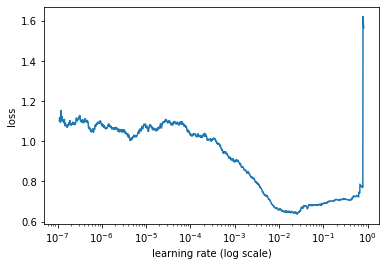

In [8]:
learner_mod.lr_plot()

In [9]:
learner_mod.autofit(0.0007, 8)



begin training using triangular learning rate policy with max lr of 0.0007...
Train on 25000 samples, validate on 25000 samples
Epoch 1/8
25000/25000 [==============================] - 221s 9ms/sample - loss: 0.8499 - acc: 0.5524 - val_loss: 0.5757 - val_acc: 0.7632
Epoch 2/8
25000/25000 [==============================] - 220s 9ms/sample - loss: 0.6227 - acc: 0.6657 - val_loss: 0.4825 - val_acc: 0.8141
Epoch 3/8
25000/25000 [==============================] - 220s 9ms/sample - loss: 0.5000 - acc: 0.7556 - val_loss: 0.4043 - val_acc: 0.8396
Epoch 4/8
25000/25000 [==============================] - 220s 9ms/sample - loss: 0.4044 - acc: 0.8181 - val_loss: 0.3516 - val_acc: 0.8542
Epoch 5/8
25000/25000 [==============================] - 220s 9ms/sample - loss: 0.3305 - acc: 0.8614 - val_loss: 0.3217 - val_acc: 0.8632
Epoch 6/8
25000/25000 [==============================] - 220s 9ms/sample - loss: 0.2727 - acc: 0.8888 - val_loss: 0.3049 - val_acc: 0.8700
Epoch 7/8
25000/25000 [=============

In [0]:
predicting = ktrain.get_predictor(learner_mod.model, preproc)

In [0]:
data = [ 'This movie was horrible! The plot was boring. Acting was okay, though.',
         'The film really sucked. I want my money back.',
        'What a beautiful romantic comedy. 10/10 would see again!']

In [12]:
predicting.predict(data)

['neg', 'neg', 'pos']

# 5. BERT Model

Import dependant libraries

In [10]:
(x_tr, y_tr), (x_tst, y_tst), preproc = text.texts_from_folder(data_full,
                                                                       maxlen=500,
                                                                       preprocess_mode='bert',
                                                                       classes=folder_names
                                                                      )

detected encoding: utf-8
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [11]:
learner_ktrain = ktrain.get_learner(text.text_classifier('bert',(x_tr,y_tr),preproc=preproc),
                                                train_data=(x_tr,y_tr),
                                                val_data=(x_tst, y_tst),
                                                batch_size=3)

Is Multi-Label? False
maxlen is 500
done.


simulating training for different learning rates... this may take a few moments...
Train on 25000 samples
Epoch 1/1024
 3396/25000 [===>..........................] - ETA: 31:19 - loss: 0.7134 - acc: 0.5895

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


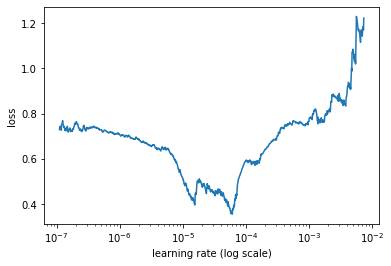

In [12]:
learner_ktrain.lr_find()
learner_ktrain.lr_plot()

In [13]:
learner_ktrain.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 2769s 111ms/sample - loss: 0.2531 - acc: 0.8955 - val_loss: 0.2008 - val_acc: 0.9214
Epoch 2/3
25000/25000 [==============================] - 2770s 111ms/sample - loss: 0.1604 - acc: 0.9406 - val_loss: 0.1661 - val_acc: 0.9375
Epoch 3/3
25000/25000 [==============================] - 2772s 111ms/sample - loss: 0.0523 - acc: 0.9832 - val_loss: 0.1954 - val_acc: 0.9410
